In [1]:
!pip install -q pandas_ta==0.3.14b0
!pip install bayesian-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [13]:
import pandas as pd


# Load the dataset
data = pd.read_csv('/content/NZDUSD_5Y.csv')

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])


# Preview cleaned data
data


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-08-10,0.660062,0.661300,0.657890,0.660110,0.660110,0
1,2020-08-11,0.659278,0.662752,0.657259,0.659348,0.659348,0
2,2020-08-12,0.656991,0.659909,0.653368,0.656940,0.656940,0
3,2020-08-13,0.658042,0.659748,0.655510,0.657648,0.657648,0
4,2020-08-14,0.654639,0.655991,0.652742,0.654729,0.654729,0
...,...,...,...,...,...,...,...
1297,2025-08-04,0.591569,0.593021,0.590441,0.591419,0.591419,0
1298,2025-08-05,0.591849,0.592259,0.588260,0.591698,0.591698,0
1299,2025-08-06,0.590849,0.593849,0.590570,0.590929,0.590929,0
1300,2025-08-07,0.592810,0.596691,0.592421,0.592849,0.592849,0


In [14]:
import pandas as pd
import numpy as np

# Load your data
# Example: data = pd.read_csv('/content/EURUSD.csv')

# Shifted closing prices for previous days
data['T-4'] = data['Close']
data['T-3'] = data['Close'].shift(-1)
data['T-2'] = data['Close'].shift(-2)
data['T-1'] = data['Close'].shift(-3)
data['T0']  = data['Close'].shift(-4)

# Simple Moving Averages (5-day)
data['SMA_5_H'] = data['High'].rolling(window=5).mean().shift(-4)
data['SMA_5_L'] = data['Low'].rolling(window=5).mean().shift(-4)

# Exponential Moving Average (5-day)
data['EMA_5_C'] = data['Close'].ewm(span=5, adjust=False).mean().shift(-4)

# RSI (Relative Strength Index, 14-day)
delta = data['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))
data['RSI'] = rsi.shift(-14)

# Future target closing price
data['T_F'] = data['Close'].shift(-5)

# Show first few rows
print(data.head(10))


        Date      Open      High       Low     Close  Adj Close  Volume  \
0 2020-08-10  0.660062  0.661300  0.657890  0.660110   0.660110       0   
1 2020-08-11  0.659278  0.662752  0.657259  0.659348   0.659348       0   
2 2020-08-12  0.656991  0.659909  0.653368  0.656940   0.656940       0   
3 2020-08-13  0.658042  0.659748  0.655510  0.657648   0.657648       0   
4 2020-08-14  0.654639  0.655991  0.652742  0.654729   0.654729       0   
5 2020-08-17  0.654440  0.655411  0.652061  0.654382   0.654382       0   
6 2020-08-18  0.655428  0.660502  0.653599  0.655471   0.655471       0   
7 2020-08-19  0.660869  0.665199  0.660118  0.661039   0.661039       0   
8 2020-08-20  0.655970  0.657300  0.649110  0.656159   0.656159       0   
9 2020-08-21  0.654181  0.654999  0.651861  0.654211   0.654211       0   

        T-4       T-3       T-2       T-1        T0   SMA_5_H   SMA_5_L  \
0  0.660110  0.659348  0.656940  0.657648  0.654729  0.659940  0.655354   
1  0.659348  0.656940  0

In [15]:
print(data.tail(10))

           Date      Open      High       Low     Close  Adj Close  Volume  \
1292 2025-07-28  0.602080  0.603289  0.596930  0.601931   0.601931       0   
1293 2025-07-29  0.597190  0.597672  0.594400  0.597190   0.597190       0   
1294 2025-07-30  0.595749  0.597179  0.591031  0.595461   0.595461       0   
1295 2025-07-31  0.590762  0.593750  0.589119  0.590769   0.590769       0   
1296 2025-08-01  0.588769  0.592909  0.585789  0.588869   0.588869       0   
1297 2025-08-04  0.591569  0.593021  0.590441  0.591419   0.591419       0   
1298 2025-08-05  0.591849  0.592259  0.588260  0.591698   0.591698       0   
1299 2025-08-06  0.590849  0.593849  0.590570  0.590929   0.590929       0   
1300 2025-08-07  0.592810  0.596691  0.592421  0.592849   0.592849       0   
1301 2025-08-08  0.596125  0.597336  0.595096  0.596019   0.596019       0   

           T-4       T-3       T-2       T-1        T0   SMA_5_H   SMA_5_L  \
1292  0.601931  0.597190  0.595461  0.590769  0.588869  0.59696

In [16]:
# Dropping NaN values
data.dropna(inplace=True)

print(data.tail(10))


           Date      Open      High       Low     Close  Adj Close  Volume  \
1278 2025-07-08  0.600889  0.602969  0.598111  0.600781   0.600781       0   
1279 2025-07-09  0.599351  0.601478  0.597750  0.599359   0.599359       0   
1280 2025-07-10  0.599959  0.602600  0.599710  0.599840   0.599840       0   
1281 2025-07-11  0.604200  0.604200  0.600218  0.604171   0.604171       0   
1282 2025-07-14  0.600860  0.601600  0.597211  0.600691   0.600691       0   
1283 2025-07-15  0.597129  0.600619  0.594011  0.597190   0.597190       0   
1284 2025-07-16  0.595688  0.596961  0.591401  0.595429   0.595429       0   
1285 2025-07-17  0.594552  0.594552  0.590800  0.594590   0.594590       0   
1286 2025-07-18  0.594530  0.599129  0.594350  0.594431   0.594431       0   
1287 2025-07-21  0.595320  0.598569  0.594040  0.595281   0.595281       0   

           T-4       T-3       T-2       T-1        T0   SMA_5_H   SMA_5_L  \
1278  0.600781  0.599359  0.599840  0.604171  0.600691  0.60257

In [17]:
data = data[['Date', 'T-4','T-3','T-2','T-1','T0','SMA_5_H','SMA_5_L','EMA_5_C','RSI','T_F']]

data

,Date,T-4,T-3,T-2,T-1,T0,SMA_5_H,SMA_5_L,EMA_5_C,RSI,T_F
0,2020-08-10,0.660110,0.659348,0.656940,0.657648,0.654729,0.659940,0.655354,0.657224,56.624730,0.654382
1,2020-08-11,0.659348,0.656940,0.657648,0.654729,0.654382,0.658762,0.654188,0.656277,67.816473,0.655471
2,2020-08-12,0.656940,0.657648,0.654729,0.654382,0.655471,0.658312,0.653456,0.656008,69.675351,0.661039
3,2020-08-13,0.657648,0.654729,0.654382,0.655471,0.661039,0.659370,0.654806,0.657685,71.651739,0.656159
4,2020-08-14,0.654729,0.654382,0.655471,0.661039,0.656159,0.658881,0.653526,0.657177,76.495460,0.654211
...,...,...,...,...,...,...,...,...,...,...,...
1283,2025-07-15,0.597190,0.595429,0.594590,0.594431,0.595281,0.597966,0.592920,0.596021,40.859772,0.596961
1284,2025-07-16,0.595429,0.594590,0.594431,0.595281,0.596961,0.597866,0.592962,0.596334,43.800167,0.600010
1285,2025-07-17,0.594590,0.594431,0.595281,0.596961,0.600010,0.599428,0.594592,0.597559,43.902004,0.604781
1286,2025-07-18,0.594431,0.595281,0.596961,0.600010,0.604781,0.601738,0.597176,0.599967,47.510555,0.603712


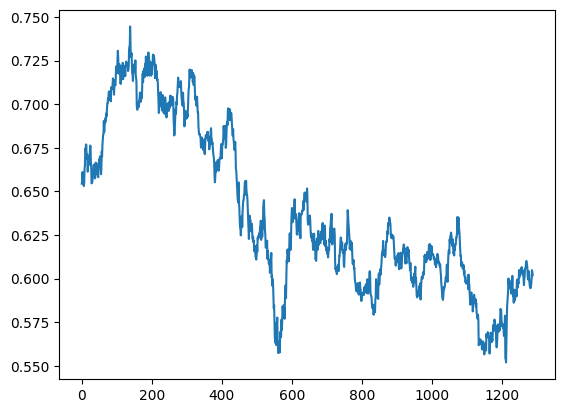

In [18]:
import matplotlib.pyplot as plt

plt.plot(data.index, data['T_F'])

In [19]:
dates=data['Date'].to_numpy()
middle_matrix =data[['T-4','T-3','T-2','T-1','T0','SMA_5_H','SMA_5_L','EMA_5_C','RSI']].to_numpy()
X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
Y=data['T_F']

print(dates.shape)
print(X.shape)
print(Y.shape)

(1288,)
(1288, 9, 1)
(1288,)


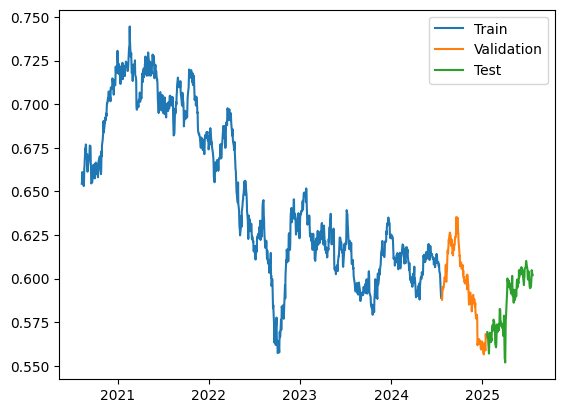

In [20]:
q_80 = int(len(dates) * .8) #change to 0.8
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], Y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], Y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], Y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
import numpy as np
import time

def evaluate_network(lstm_units_1,epochs,learning_rate,dense_units_1,dense_units_2):

  lstm_units_1=int(lstm_units_1)
  epochs=int(epochs)
  dense_units_1=int(dense_units_1)
  dense_units_2=int(dense_units_2)

  model = Sequential([layers.Input((9, 1)),
                      layers.LSTM(lstm_units_1),
                      layers.Dense(dense_units_1, activation='relu'),
                      layers.Dense(dense_units_2, activation='relu'),
                      layers.Dense(1)])

  model.compile(loss='mse',
                optimizer=Adam(learning_rate=learning_rate),
                metrics=['mean_absolute_error'])


  # Train the model
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, verbose=0)

  # Return the loss (or another metric that you want to minimize)
  val_loss=min(history.history['val_loss'])
  loss=min(history.history['loss'])

  return -(val_loss*loss)  # Negative because BayesianOptimization maximizes, but we want to minimize loss



pbounds = {
    'lstm_units_1': (20, 300),
    'learning_rate': (1e-6, 1e-2),
    'epochs': (10, 150),
    'dense_units_1': (10, 200),
    'dense_units_2': (10, 200)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=evaluate_network,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
    )

# Run the optimization
start_time = time.time()
optimizer.maximize(init_points=20, n_iter=40)
time_took = (time.time() - start_time)/60


# Get the best hyperparameters
print(f"Total runtime in mins: {time_took}")
best_params = optimizer.max['params']
print(f"Best hyperparameters: {best_params}")


|   iter    |  target   | lstm_u... | learni... |  epochs   | dense_... | dense_... |
-------------------------------------------------------------------------------------
| 1         | -1.85e-09 | 136.76616 | 0.0072035 | 10.016012 | 67.443188 | 37.883619 |
| 2         | -6.96e-10 | 45.854806 | 0.0018634 | 58.378501 | 85.385820 | 112.37517 |
| 3         | -7.25e-10 | 137.37446 | 0.0068525 | 38.623314 | 176.84231 | 15.203642 |
| 4         | -8.54e-10 | 207.73090 | 0.0041736 | 88.216575 | 36.673518 | 47.639282 |
| 5         | -1.08e-09 | 244.20847 | 0.0096826 | 53.879384 | 141.54129 | 176.51393 |
| 6         | -1.63e-09 | 270.48986 | 0.0008513 | 15.467669 | 42.267779 | 176.84707 |
| 7         | -6.06e-10 | 47.537113 | 0.0042116 | 144.10453 | 111.30140 | 141.45665 |
| 8         | -6.46e-10 | 108.34437 | 0.0068653 | 126.84759 | 13.474772 | 152.52741 |
| 9         | -1.12e-09 | 296.88110 | 0.0074819 | 49.262158 | 159.96307 | 29.612941 |
| 10        | -1.02e-09 | 145.41018 | 0.0090860 | 51.1

Epoch 1/122
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0887 - mean_absolute_error: 0.2224 - val_loss: 4.8939e-04 - val_mean_absolute_error: 0.0182
Epoch 2/122
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mean_absolute_error: 0.0444 - val_loss: 0.0026 - val_mean_absolute_error: 0.0470
Epoch 3/122
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0387 - val_loss: 0.0035 - val_mean_absolute_error: 0.0555
Epoch 4/122
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mean_absolute_error: 0.0395 - val_loss: 0.0040 - val_mean_absolute_error: 0.0594
Epoch 5/122
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mean_absolute_error: 0.0401 - val_loss: 0.0034 - val_mean_absolute_error: 0.0544
Epoch 6/122
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_absolute_error: 0.0395 - val_loss: 0.0017 - val_mean_absolute_error: 0.0364
Epoch 7/122
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mean_absolute_error: 0.0381 - val

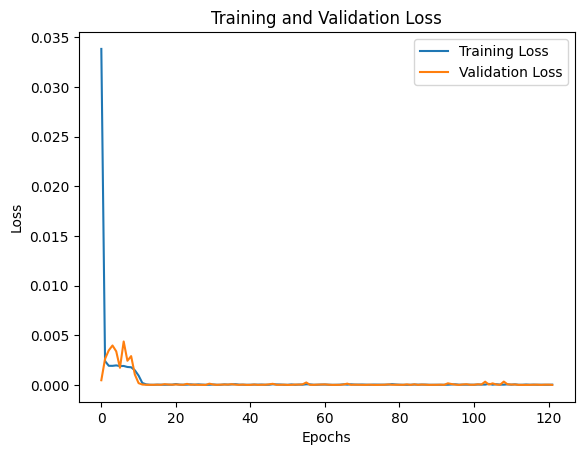

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# model = Sequential([layers.Input((9, 1)),
#                     layers.LSTM(64),
#                     layers.Dense(1)])

model = Sequential([layers.Input((9, 1)),
                   layers.LSTM(31),
                   layers.Dense(103, activation='relu'),
                   layers.Dense(159, activation='relu'),
                   layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0022685099867691518),
              metrics=['mean_absolute_error'])


history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=122)

print(history.history.keys())

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


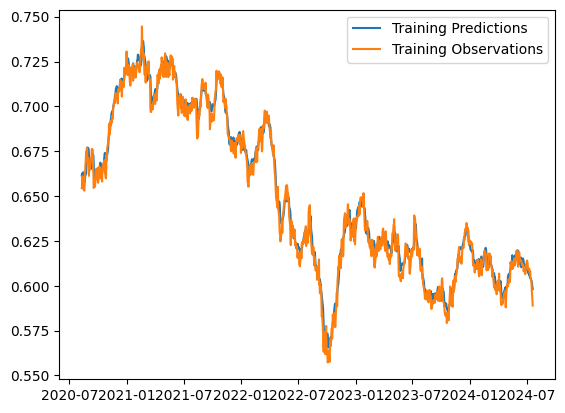

In [23]:
from sklearn.metrics import mean_squared_error

train_predictions = model.predict(X_train).flatten()
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

40.87821706871974


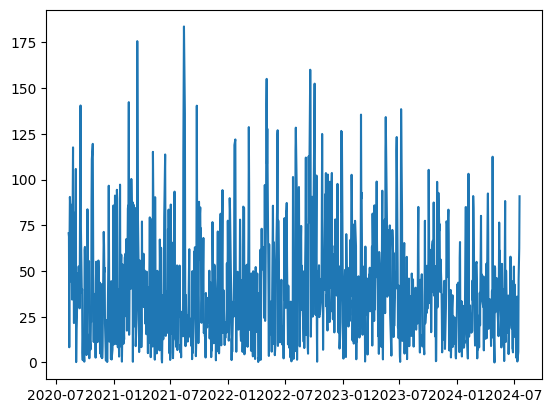

In [24]:
import numpy as np

basis_point_value=0.0001  #For EURUSD pair
train_data_basis_point_diff=((train_predictions/basis_point_value).flatten()-y_train/basis_point_value).abs()
plt.plot(dates_train, train_data_basis_point_diff)

average_train_data_basis_point_diff=np.mean(train_data_basis_point_diff)
print(average_train_data_basis_point_diff)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


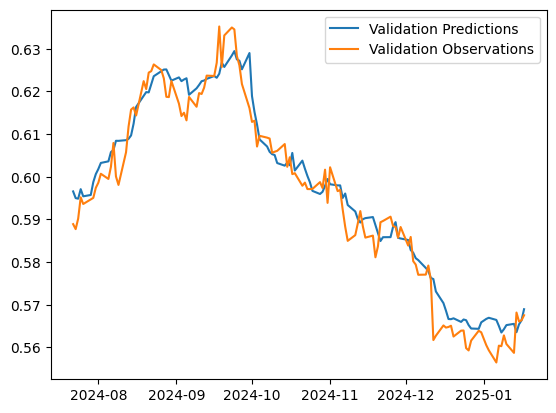

In [25]:
val_predictions = model.predict(X_val).flatten()
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

36.82354044331404


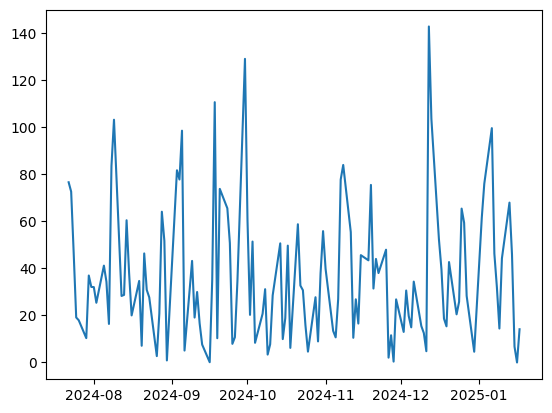

In [26]:
basis_point_value=0.0001  #For EURUSD pair
validation_data_basis_point_diff=((val_predictions/basis_point_value).flatten()-y_val/basis_point_value).abs()
plt.plot(dates_val, validation_data_basis_point_diff)

print(np.mean(validation_data_basis_point_diff))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


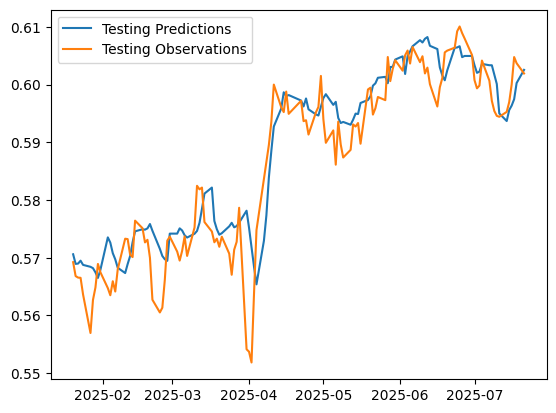

In [27]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Assuming test_predictions and y_test are lists or numpy arrays
# Calculate MSE and MAE
mse = mean_squared_error(y_test, test_predictions)
print("Mean Square Error:", mse)
mae=mean_absolute_error(y_test, test_predictions)
print("Mean Absolute Error:", mae)

Mean Square Error: 3.329482834468144e-05
Mean Absolute Error: 0.00424915553044945


42.491610839389686


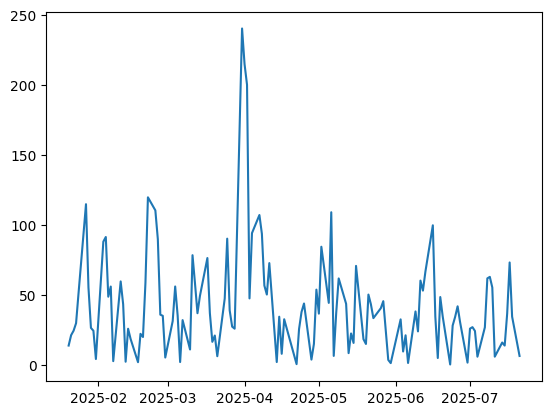

In [30]:
basis_point_value=0.0001  #For AUDUSD pair
test_data_basis_point_diff=((test_predictions/basis_point_value).flatten()-y_test/basis_point_value).abs()
plt.plot(dates_test, test_data_basis_point_diff)

print(np.mean(test_data_basis_point_diff))

In [31]:
#Start Trading with 1000 USD with model


number_of_trading_days=dates_test.size
test_data=y_test.values
holding_currency="quote"
holding_value=1000
for current_trading_day in range(number_of_trading_days-1):
  if holding_currency=="quote":
    if (test_predictions[current_trading_day+1]>test_data[current_trading_day]):
      holding_value=holding_value/test_data[current_trading_day]
      holding_currency="base"
  else:
    if (test_predictions[current_trading_day+1]<test_data[current_trading_day]):
      holding_value=test_data[current_trading_day]*holding_value
      holding_currency="quote"


if holding_currency=="base":
  holding_value=test_data[current_trading_day]*holding_value

print(number_of_trading_days)
print(holding_value)
print(holding_currency)


129
1119.159892924166
quote


In [32]:
#Start Trading with 1000 USD with actual values


number_of_trading_days=dates_test.size
test_data=y_test.values
holding_currency="quote"
holding_value=1000
for current_trading_day in range(number_of_trading_days-1):
  if holding_currency=="quote":
    if (test_data[current_trading_day+1]>test_data[current_trading_day]):
      holding_value=holding_value/test_data[current_trading_day]
      holding_currency="base"
  else:
    if (test_data[current_trading_day+1]<test_data[current_trading_day]):
      holding_value=test_data[current_trading_day]*holding_value
      holding_currency="quote"


if holding_currency=="base":
  holding_value=test_data[current_trading_day]*holding_value

print(number_of_trading_days)
print(holding_value)
print(holding_currency)

129
1447.3902515013806
quote


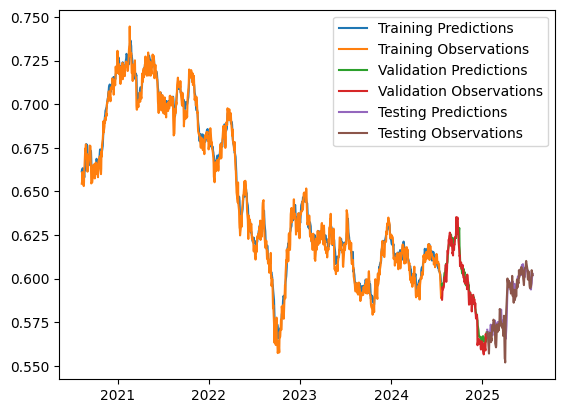

In [33]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])